In [16]:
import scipy
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
from scipy.spatial.distance import directed_hausdorff


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def directed_hausdorff_brute_force(u, v):
    return max(np.amin(scipy.spatial.distance.cdist(u,v), axis = 1))

def MDA_hausdorff(u, v):
    '''3-D only transplant of the MDAnalysis implementation, adjusted
    to calculate directed Hausdorff only.'''
    N = 1
    axis = (1,)
    
    def sqnorm(v, axis=None):
        return np.sum(v*v, axis=axis)
    
    d = np.asarray([sqnorm(p - v, axis=axis) for p in u])
    return (np.amax(np.amin(d, axis=1)) / N) ** 0.5
    
    


In [4]:
from Cython.Compiler.Options import directive_defaults

directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

In [11]:
%%cython -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
def directed_hausdorff_hardcoded_3d(np.ndarray[np.float64_t, ndim =2] ar1, np.ndarray[np.float64_t, ndim =2] ar2):

    cdef double cmax, cmin
    cdef int break_occurred
    cdef int N1 = ar1.shape[0]
    cdef int N2 = ar2.shape[0]
    cdef int data_dims = ar1.shape[1]
    cdef double square_distance = 0
    cdef np.float64_t d
    cdef unsigned int i, j
    
    # shuffling the points in each array generally increases the likelihood of
    # an advantageous break in the inner search loop and never decreases the
    # performance of the algorithm
    
    np.random.shuffle(ar1)
    np.random.shuffle(ar2)
                                                                                                                                                                                                     
    cmax = 0 
    for i in range(N1):
        break_occurred = 0
        cmin = np.inf
        for j in range(N2):
            d = ((ar1[i,0] - ar2[j,0]) * (ar1[i,0] - ar2[j,0])) + \
                ((ar1[i,1] - ar2[j,1]) * (ar1[i,1] - ar2[j,1])) + \
                ((ar1[i,2] - ar2[j,2]) * (ar1[i,2] - ar2[j,2]))
            if d < cmax: # early break
                break_occurred += 1
                break
            if d < cmin:
                cmin = d
        if cmin > cmax and cmin != np.inf and break_occurred == 0:
            cmax = cmin
    return sqrt(cmax)


In [12]:
def test_approach(func, u, v, num_times = 3):
    times = []
    for i in range(num_times):
        start = time.time()
        d = func(u,v)
        end = time.time()
        times.append(end - start)
    print 'd:', d
    return np.mean(times)


In [23]:
# interleave performance tests
brute_times = []
new_algorithm_times = []
scipy_algorithm_times = []
MDA_algorithm_times = []
total_points = np.linspace(400,50000,num=40)
for point_total in total_points:
    points_per_array = int(point_total / 2)
    u = np.random.random((points_per_array, 3))
    v = np.random.random((points_per_array, 3))
    
    # brute force approach bench
    brute_force_avg_time = test_approach(directed_hausdorff_brute_force, u, v, num_times = 3)
    brute_times.append(brute_force_avg_time)
    
    # new algorithm bench with hardcoding
    new_algorithm_avg_time = test_approach(directed_hausdorff_hardcoded_3d, u, v, num_times = 3)
    new_algorithm_times.append(new_algorithm_avg_time)
    
    # the scipy.spatial.distance implementation
    scipy_algorithm_avg_time = test_approach(directed_hausdorff, u, v, num_times = 3)
    scipy_algorithm_times.append(scipy_algorithm_avg_time)
    
    # the transplanted MDAnalysis implementation
    MDA_algorithm_avg_time = test_approach(MDA_hausdorff, u, v, num_times = 3)
    MDA_algorithm_times.append(MDA_algorithm_avg_time)

d: 0.241660578187
d: 0.241660578187
d: 0.241660578187
d: 0.241660578187
d: 0.144782056032
d: 0.144782056032
d: 0.144782056032
d: 0.144782056032
d: 0.130163378008
d: 0.130163378008
d: 0.130163378008
d: 0.130163378008
d: 0.106562923217
d: 0.106562923217
d: 0.106562923217
d: 0.106562923217
d: 0.101729835695
d: 0.101729835695
d: 0.101729835695
d: 0.101729835695
d: 0.123149902307
d: 0.123149902307
d: 0.123149902307
d: 0.123149902307
d: 0.10476570046
d: 0.10476570046
d: 0.10476570046
d: 0.10476570046
d: 0.101532655644
d: 0.101532655644
d: 0.101532655644
d: 0.101532655644
d: 0.0833871875347
d: 0.0833871875347
d: 0.0833871875347
d: 0.0833871875347
d: 0.0934900738654
d: 0.0934900738654
d: 0.0934900738654
d: 0.0934900738654
d: 0.083500136551
d: 0.083500136551
d: 0.083500136551
d: 0.083500136551
d: 0.0811533587127
d: 0.0811533587127
d: 0.0811533587127
d: 0.0811533587127
d: 0.0710499729861
d: 0.0710499729861
d: 0.0710499729861
d: 0.0710499729861
d: 0.0754509311284
d: 0.0754509311284
d: 0.075450931

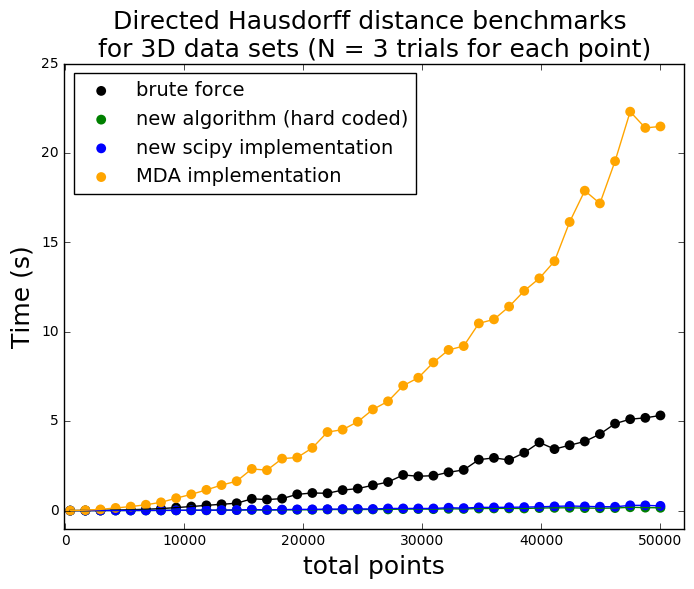

In [27]:
fig = plt.figure()
ax = fig.add_subplot('111')
ax.scatter(total_points, brute_times, color = 'black', edgecolor='none', label = 'brute force', s = 50)
ax.plot(total_points, brute_times, color = 'black')
ax.scatter(total_points, new_algorithm_times, color = 'green', edgecolor='none', label = 'new algorithm (hard coded)', s = 50)
ax.plot(total_points, new_algorithm_times, color = 'green')
ax.scatter(total_points, scipy_algorithm_times, color = 'blue', edgecolor='none', label = 'new scipy implementation', s = 50)
ax.plot(total_points, scipy_algorithm_times, color = 'blue')
ax.scatter(total_points, MDA_algorithm_times, color = 'orange', edgecolor='none', label = 'MDA implementation', s = 50)
ax.plot(total_points, MDA_algorithm_times, color = 'orange')
ax.legend(loc=2, scatterpoints=1, fontsize=14)
ax.set_ylabel('Time (s)', fontsize = 18)
ax.set_xlabel('total points', fontsize = 18)
ax.set_title('Directed Hausdorff distance benchmarks \nfor 3D data sets (N = 3 trials for each point)', fontsize = 18)
ax.set_xlim(-100,52000)
ax.set_ylim(-1,25)
fig.set_size_inches(8,6)
fig.savefig('hausdorff_bench.png', dpi = 300)

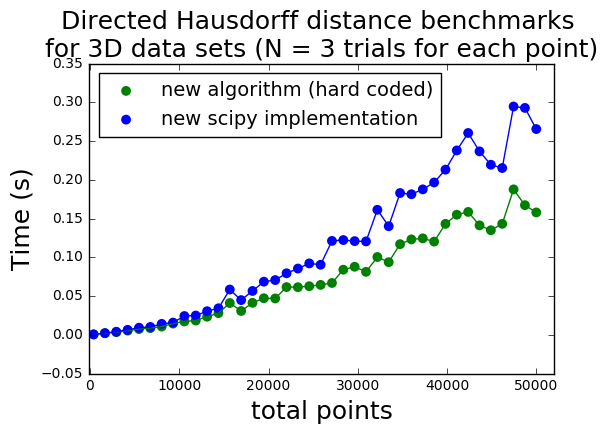

In [28]:
# high perf comparison plot
fig2 = plt.figure()
ax = fig2.add_subplot('111')

ax.scatter(total_points, new_algorithm_times, color = 'green', edgecolor='none', label = 'new algorithm (hard coded)', s = 50)
ax.plot(total_points, new_algorithm_times, color = 'green')
ax.scatter(total_points, scipy_algorithm_times, color = 'blue', edgecolor='none', label = 'new scipy implementation', s = 50)
ax.plot(total_points, scipy_algorithm_times, color = 'blue')
ax.legend(loc=2, scatterpoints=1, fontsize=14)
ax.set_ylabel('Time (s)', fontsize = 18)
ax.set_xlabel('total points', fontsize = 18)
ax.set_title('Directed Hausdorff distance benchmarks \nfor 3D data sets (N = 3 trials for each point)', fontsize = 18)
ax.set_xlim(-100,52000)
fig.set_size_inches(8,6)
fig.savefig('hausdorff_bench_zoom.png', dpi = 300)